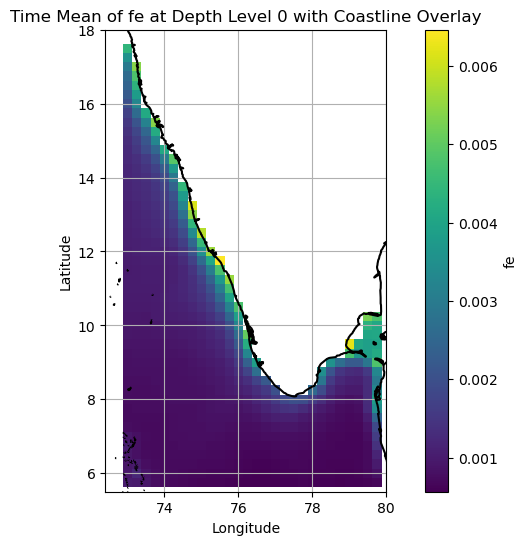

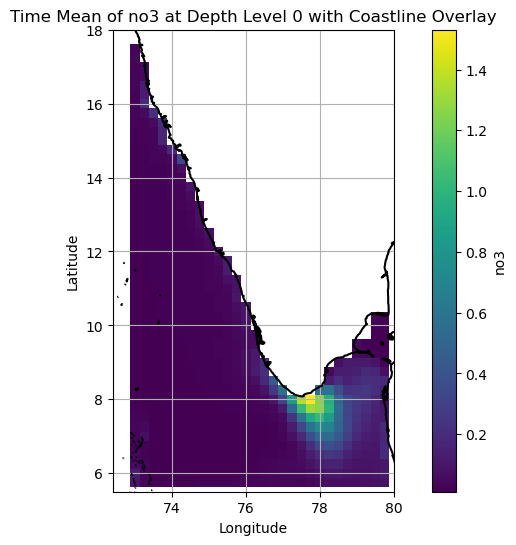

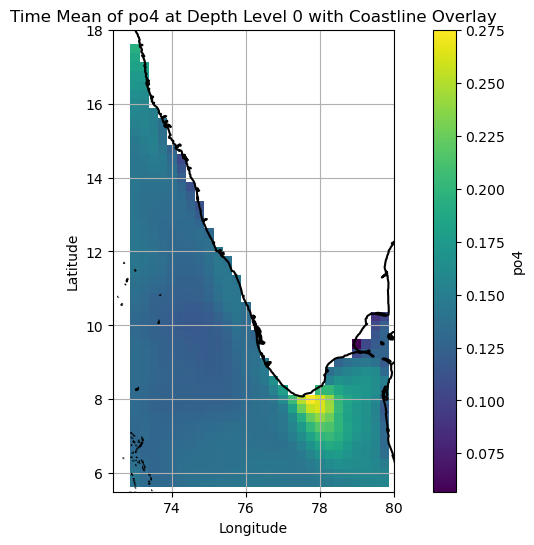

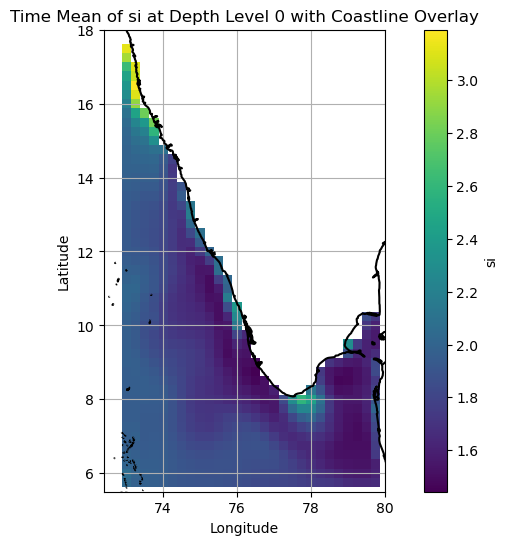

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

# Path to the NetCDF file
netcdf_file = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\CROCO.nc"

# Path to the coastline shapefile
shapefile_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\ne_10m_coastline\ne_10m_coastline.shp"

# Load coastlines data
try:
    world = gpd.read_file(shapefile_path)
    # Optionally, ensure the coastlines are in the correct CRS
    # world = world.to_crs(epsg=4326)  # Use this if needed
except Exception as e:
    print(f"Error loading shapefile: {e}")
    world = None

# Open the NetCDF file
try:
    ds = xr.open_dataset(netcdf_file)
except Exception as e:
    print(f"Error opening NetCDF file: {e}")
    ds = None

def plot_time_mean_with_coastline(variable, dataset, coastline):
    try:
        # Calculate the time mean
        time_mean = dataset[variable].mean(dim='time')
        
        # Check if the variable has a depth dimension
        if 'depth' in time_mean.dims:
            # Create a new figure for plotting
            plt.figure(figsize=(10, 6))
            
            # Plot the time-mean value at the first depth level
            time_mean.isel(depth=0).plot(cmap='viridis', add_colorbar=True)
            
            # Overlay the coastline in black
            if coastline is not None:
                # Plot coastline as a line (instead of boundary)
                coastline.plot(ax=plt.gca(), color='black', linewidth=1.5, edgecolor='black')
            
            plt.title(f"Time Mean of {variable} at Depth Level 0 with Coastline Overlay")
            plt.xlabel("Longitude")
            plt.ylabel("Latitude")
            plt.xlim([72.4, 80])  # Adjust based on your data's longitude range
            plt.ylim([5.5, 18])    # Adjust based on your data's latitude range
            plt.grid(True)          # Optional: Add grid for better visualization
            plt.show()
        else:
            print(f"The variable '{variable}' does not have a depth dimension.")
    
    except KeyError:
        print(f"The variable '{variable}' was not found in the dataset.")
    except Exception as e:
        print(f"An error occurred while processing {variable}: {e}")

if ds:
    # List of variables to process
    variables = ['fe', 'no3', 'po4', 'si']

    for var in variables:
        plot_time_mean_with_coastline(var, ds, world)
else:
    print("Dataset could not be loaded.")


In [37]:
import xarray as xr
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
netcdf_file = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\CROCO.nc"
ds = xr.open_dataset(netcdf_file)

# Extract data variables
fe = ds['fe'].values  # (time, depth, lat, lon)
po4 = ds['po4'].values
si = ds['si'].values
no3 = ds['no3'].values

# Extract latitude and longitude
latitude = ds['latitude'].values  # Shape: (48,)
longitude = ds['longitude'].values  # Shape: (28,)

# Since depth is constant, we'll discard the depth dimension and focus on (time, lat, lon)
fe = fe[:, 0, :, :]
po4 = po4[:, 0, :, :]
si = si[:, 0, :, :]
no3 = no3[:, 0, :, :]

# Remove NaN values from the NO3 data for processing
no3 = np.nan_to_num(no3, nan=np.nanmean(no3))  # Replace NaN with the mean of the available values

# Stack the input variables along a new channel dimension (fe, po4, si)
inputs = np.stack([fe, po4, si], axis=-1)  # Shape: (time, lat, lon, channels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, no3, test_size=0.2, random_state=42)

# Normalize the data
scaler_X = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
X_test_reshaped = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2] * X_test.shape[3])
X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[1] * y_train.shape[2])).reshape(y_train.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, y_test.shape[1] * y_test.shape[2])).reshape(y_test.shape)

# Define the 2D CNN model with adjusted layers
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1] * y_train.shape[2])  # Output shape is flattened (lat * lon)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train_scaled.reshape(y_train_scaled.shape[0], -1), 
                    epochs=50, batch_size=16, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test_scaled, y_test_scaled.reshape(y_test_scaled.shape[0], -1))

# Make predictions
predictions = model.predict(X_test_scaled)
predicted_no3 = scaler_y.inverse_transform(predictions.reshape(-1, y_test.shape[1] * y_test.shape[2])).reshape(y_test.shape)

print("Test Loss:", test_loss)

# Compute average actual and predicted NO3 across time steps
average_actual = np.nanmean(y_test, axis=0)  # Average across time dimension
average_predicted = np.nanmean(predicted_no3, axis=0)  # Average across time dimension

# Visualization function
# After computing average actual and predicted NO3 across time steps
average_actual = np.nanmean(y_test, axis=0)  # Average across time dimension
average_predicted = np.nanmean(predicted_no3, axis=0)  # Average across time dimension

# Define output file path
output_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\average_no3_output.nc"

# Create a new NetCDF file
with xr.Dataset() as ds_out:
    # Create dimensions
    ds_out.coords['latitude'] = ('latitude', latitude)
    ds_out.coords['longitude'] = ('longitude', longitude)

    # Add actual NO3 and predicted NO3 as variables
    ds_out['average_actual_no3'] = (('latitude', 'longitude'), average_actual)
    ds_out['average_predicted_no3'] = (('latitude', 'longitude'), average_predicted)

    # Set attributes for the dataset and variables
    ds_out.attrs['title'] = 'Average NO3 Concentrations'
    ds_out.attrs['description'] = 'Contains average actual and predicted NO3 concentrations'
    
    ds_out['average_actual_no3'].attrs['units'] = 'mmol m-3'
    ds_out['average_predicted_no3'].attrs['units'] = 'mmol m-3'
    
    # Save the dataset to a NetCDF file
    ds_out.to_netcdf(output_file_path)

print(f"Output saved to: {output_file_path}")


Epoch 1/50


C:\Users\Subhadeep Maishal\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\Subhadeep Maishal\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\Subhadeep Maishal\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


15/15 [==============================] - 1s 34ms/step - loss: 0.4989 - val_loss: 0.3873
Epoch 2/50
15/15 [==============================] - 0s 25ms/step - loss: 0.4987 - val_loss: 0.3874
Epoch 3/50
15/15 [==============================] - 0s 25ms/step - loss: 0.4987 - val_loss: 0.3876
Epoch 4/50
15/15 [==============================] - 0s 26ms/step - loss: 0.4987 - val_loss: 0.3876
Epoch 5/50
15/15 [==============================] - 0s 25ms/step - loss: 0.4987 - val_loss: 0.3878
Epoch 6/50
15/15 [==============================] - 0s 25ms/step - loss: 0.4986 - val_loss: 0.3879
Epoch 7/50
15/15 [==============================] - 0s 26ms/step - loss: 0.4986 - val_loss: 0.3880
Epoch 8/50
15/15 [==============================] - 0s 25ms/step - loss: 0.4986 - val_loss: 0.3880
Epoch 9/50
15/15 [==============================] - 0s 25ms/step - loss: 0.4986 - val_loss: 0.3882
Epoch 10/50
15/15 [==============================] - 0s 24ms/step - loss: 0.4986 - val_loss: 0.3882
Epoch 11/50
15/15 [=

<xarray.Dataset> Size: 11kB
Dimensions:                (latitude: 48, longitude: 28)
Coordinates:
  * latitude               (latitude) float32 192B 5.75 6.0 6.25 ... 17.25 17.5
  * longitude              (longitude) float32 112B 73.0 73.25 ... 79.5 79.75
Data variables:
    average_actual_no3     (latitude, longitude) float32 5kB ...
    average_predicted_no3  (latitude, longitude) float32 5kB ...
Attributes:
    title:        Average NO3 Concentrations
    description:  Contains average actual and predicted NO3 concentrations


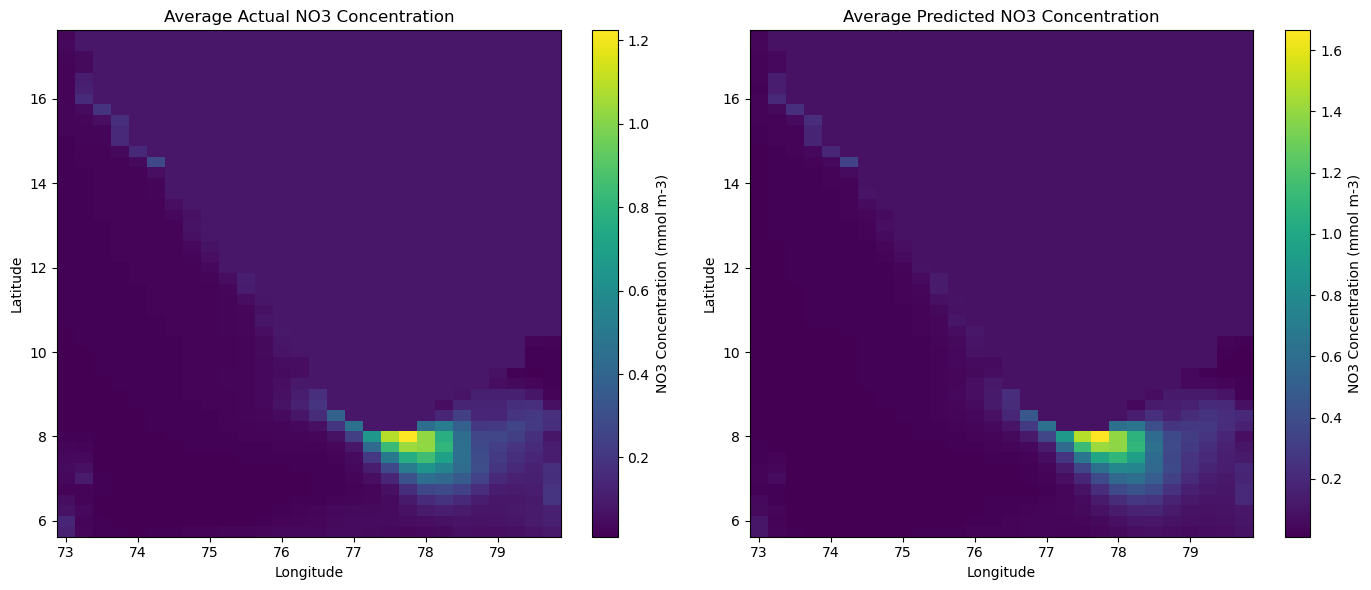

In [40]:
import xarray as xr
import matplotlib.pyplot as plt

# Define the output file path
output_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\average_no3_output.nc"

# Read the NetCDF file using xarray
ds = xr.open_dataset(output_file_path)

# Check the contents of the dataset
print(ds)

# Extract the variables you want to plot
actual_no3 = ds['average_actual_no3']
predicted_no3 = ds['average_predicted_no3']

# Create a figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the average actual NO3 concentration
actual_no3.plot(ax=ax[0], cmap='viridis', cbar_kwargs={'label': 'NO3 Concentration (mmol m-3)'})
ax[0].set_title('Average Actual NO3 Concentration')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# Plot the average predicted NO3 concentration
predicted_no3.plot(ax=ax[1], cmap='viridis', cbar_kwargs={'label': 'NO3 Concentration (mmol m-3)'})
ax[1].set_title('Average Predicted NO3 Concentration')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Close the dataset
ds.close()


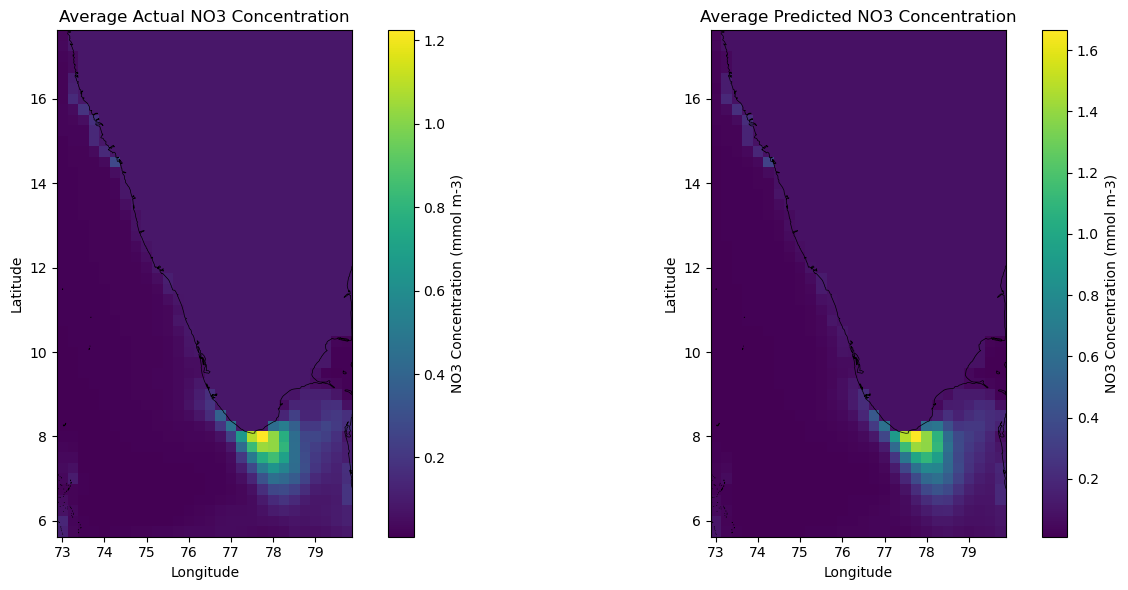

In [41]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

# Define file paths
output_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\average_no3_output.nc"
coastline_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\ne_10m_coastline\ne_10m_coastline.shp"

# Read the NetCDF file using xarray
ds = xr.open_dataset(output_file_path)

# Extract the variables you want to plot
actual_no3 = ds['average_actual_no3']
predicted_no3 = ds['average_predicted_no3']

# Read the coastline shapefile using geopandas
coastline = gpd.read_file(coastline_file_path)

# Create a figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the average actual NO3 concentration
actual_no3.plot(ax=ax[0], cmap='viridis', cbar_kwargs={'label': 'NO3 Concentration (mmol m-3)'})
ax[0].set_title('Average Actual NO3 Concentration')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# Overlay the coastline on the actual NO3 plot
coastline.plot(ax=ax[0], color='black', linewidth=0.5)

# Plot the average predicted NO3 concentration
predicted_no3.plot(ax=ax[1], cmap='viridis', cbar_kwargs={'label': 'NO3 Concentration (mmol m-3)'})
ax[1].set_title('Average Predicted NO3 Concentration')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

# Overlay the coastline on the predicted NO3 plot
coastline.plot(ax=ax[1], color='black', linewidth=0.5)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Close the dataset
ds.close()


C:\Users\Subhadeep Maishal\AppData\Local\Temp\ipykernel_7612\1372040528.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


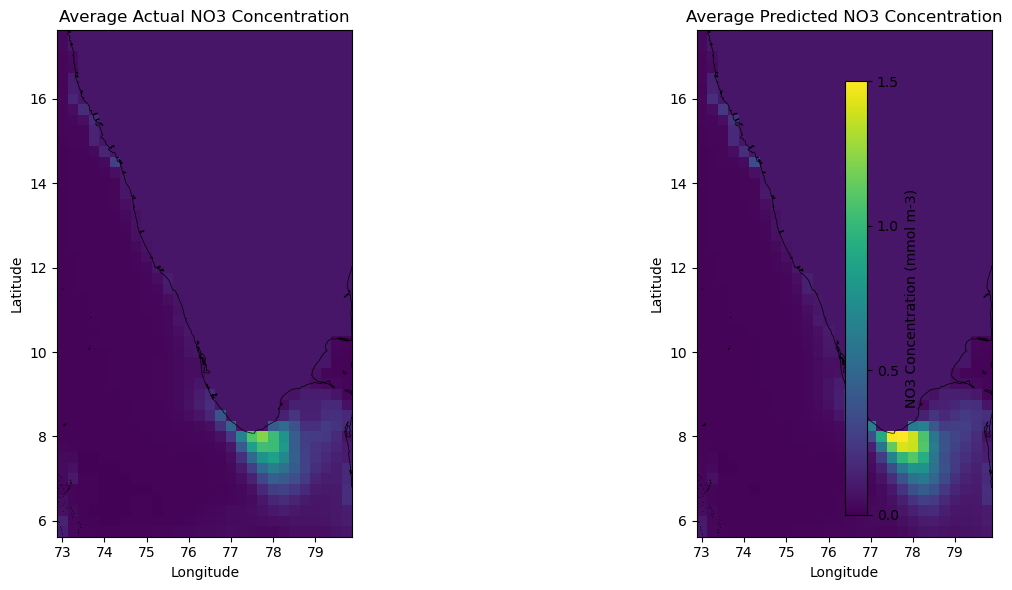

In [46]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

# Define file paths
output_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\average_no3_output.nc"
coastline_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\ne_10m_coastline\ne_10m_coastline.shp"

# Read the NetCDF file using xarray
ds = xr.open_dataset(output_file_path)

# Extract the variables you want to plot
actual_no3 = ds['average_actual_no3']
predicted_no3 = ds['average_predicted_no3']

# Read the coastline shapefile using geopandas
coastline = gpd.read_file(coastline_file_path)

# Create a figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Define common vmin and vmax
vmin = 0
vmax = 1.5

# Plot the average actual NO3 concentration
img1 = actual_no3.plot(ax=ax[0], cmap='viridis', vmin=vmin, vmax=vmax, add_colorbar=False)
ax[0].set_title('Average Actual NO3 Concentration')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# Overlay the coastline on the actual NO3 plot
coastline.plot(ax=ax[0], color='black', linewidth=0.5)

# Plot the average predicted NO3 concentration
img2 = predicted_no3.plot(ax=ax[1], cmap='viridis', vmin=vmin, vmax=vmax, add_colorbar=False)
ax[1].set_title('Average Predicted NO3 Concentration')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

# Overlay the coastline on the predicted NO3 plot
coastline.plot(ax=ax[1], color='black', linewidth=0.5)

# Create a single colorbar for both subplots using the last plot's image
cbar = fig.colorbar(img1, ax=ax, orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label('NO3 Concentration (mmol m-3)')
cbar.set_ticks([0, 0.5, 1.0, 1.5])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Close the dataset
ds.close()


C:\Users\Subhadeep Maishal\AppData\Local\Temp\ipykernel_7612\2120331422.py:56: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.05)  # Adjust this value as needed


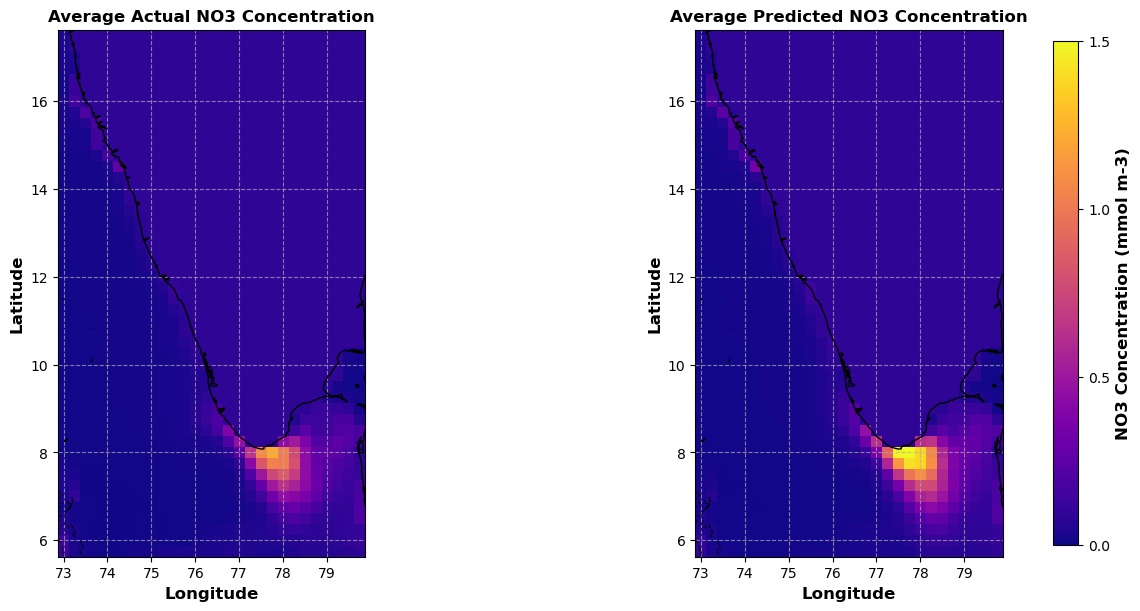

In [49]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

# Define file paths
output_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\average_no3_output.nc"
coastline_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\ne_10m_coastline\ne_10m_coastline.shp"

# Read the NetCDF file using xarray
ds = xr.open_dataset(output_file_path)

# Extract the variables you want to plot
actual_no3 = ds['average_actual_no3']
predicted_no3 = ds['average_predicted_no3']

# Read the coastline shapefile using geopandas
coastline = gpd.read_file(coastline_file_path)

# Create a figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# Define common vmin and vmax
vmin = 0
vmax = 1.5

# Customize font properties
font_properties = {'fontsize': 12, 'fontweight': 'bold'}

# Plot the average actual NO3 concentration
img1 = actual_no3.plot(ax=ax[0], cmap='plasma', vmin=vmin, vmax=vmax, add_colorbar=False)
ax[0].set_title('Average Actual NO3 Concentration', **font_properties)
ax[0].set_xlabel('Longitude', **font_properties)
ax[0].set_ylabel('Latitude', **font_properties)
ax[0].grid(True, linestyle='--', alpha=0.7)  # Add grid lines

# Overlay the coastline on the actual NO3 plot
coastline.plot(ax=ax[0], color='black', linewidth=1)

# Plot the average predicted NO3 concentration
img2 = predicted_no3.plot(ax=ax[1], cmap='plasma', vmin=vmin, vmax=vmax, add_colorbar=False)
ax[1].set_title('Average Predicted NO3 Concentration', **font_properties)
ax[1].set_xlabel('Longitude', **font_properties)
ax[1].set_ylabel('Latitude', **font_properties)
ax[1].grid(True, linestyle='--', alpha=0.7)  # Add grid lines

# Overlay the coastline on the predicted NO3 plot
coastline.plot(ax=ax[1], color='black', linewidth=1)

# Create a single colorbar for both subplots using the last plot's image
cbar = fig.colorbar(img1, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('NO3 Concentration (mmol m-3)', **font_properties)
cbar.set_ticks([0, 0.5, 1.0, 1.5])
cbar.ax.tick_params(labelsize=10)

# Adjust layout to reduce gap between figures
plt.subplots_adjust(wspace=0.05)  # Adjust this value as needed

# Show the plot
plt.show()

# Close the dataset
ds.close()


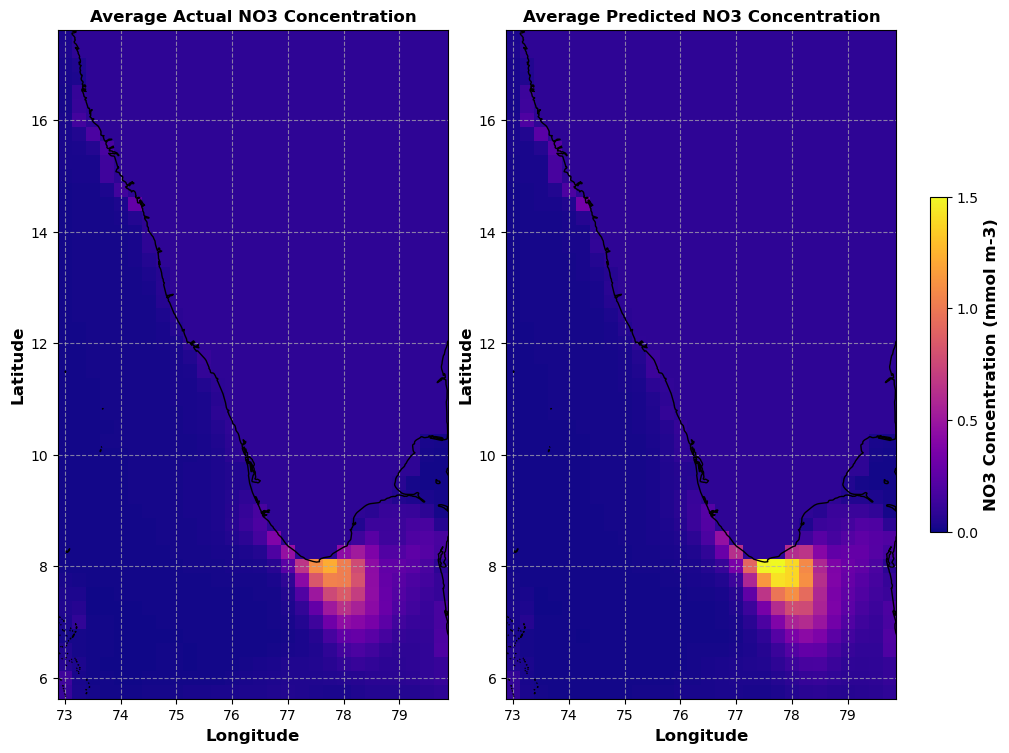

In [56]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

# Define file paths
output_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\average_no3_output.nc"
coastline_file_path = r"C:\Users\Subhadeep Maishal\Music\2D_CASE\ne_10m_coastline\ne_10m_coastline.shp"

# Read the NetCDF file using xarray
ds = xr.open_dataset(output_file_path)

# Extract the variables you want to plot
actual_no3 = ds['average_actual_no3']
predicted_no3 = ds['average_predicted_no3']

# Read the coastline shapefile using geopandas
coastline = gpd.read_file(coastline_file_path)

# Create a figure with subplots and set the gap between them
fig, ax = plt.subplots(1, 2, figsize=(10, 8), constrained_layout=True, gridspec_kw={'wspace': 0.02})

# Define common vmin and vmax
vmin = 0
vmax = 1.5

# Customize font properties
font_properties = {'fontsize': 12, 'fontweight': 'bold'}

# Plot the average actual NO3 concentration
img1 = actual_no3.plot(ax=ax[0], cmap='plasma', vmin=vmin, vmax=vmax, add_colorbar=False)
ax[0].set_title('Average Actual NO3 Concentration', **font_properties)
ax[0].set_xlabel('Longitude', **font_properties)
ax[0].set_ylabel('Latitude', **font_properties)
ax[0].grid(True, linestyle='--', alpha=0.7)  # Add grid lines

# Overlay the coastline on the actual NO3 plot
coastline.plot(ax=ax[0], color='black', linewidth=1)

# Plot the average predicted NO3 concentration
img2 = predicted_no3.plot(ax=ax[1], cmap='plasma', vmin=vmin, vmax=vmax, add_colorbar=False)
ax[1].set_title('Average Predicted NO3 Concentration', **font_properties)
ax[1].set_xlabel('Longitude', **font_properties)
ax[1].set_ylabel('Latitude', **font_properties)
ax[1].grid(True, linestyle='--', alpha=0.7)  # Add grid lines

# Overlay the coastline on the predicted NO3 plot
coastline.plot(ax=ax[1], color='black', linewidth=1)

# Create a single colorbar for both subplots using the last plot's image
cbar = fig.colorbar(img1, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('NO3 Concentration (mmol m-3)', **font_properties)
cbar.set_ticks([0, 0.5, 1.0, 1.5])
cbar.ax.tick_params(labelsize=10)

# Show the plot
plt.show()

# Close the dataset
ds.close()
